# **SEL-NNML Tuning - Kaggle Heart Failure Prediction Dataset**

This notebook implements several tuning methods on the `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model using the `Kaggle Heart Failure Prediction Dataset (KHFPD)`.

## **0. Global Configuration**

In [1]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'
OPTIMIZATION_DIRECTION='maximize'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../datasets/processed/ds1_kaggle_heart_clean.csv'
TARGET_COLUMN = 'HeartDisease'

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')
print(f'Optimization Direction: {OPTIMIZATION_DIRECTION}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy
Optimization Direction: maximize


## **1. Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from src import base_model_tuning, meta_model_tuning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import joblib

## **2. Load Dataset**

In [3]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              746 non-null    int64  
 1   Sex                              746 non-null    bool   
 2   RestingBP                        746 non-null    int64  
 3   Cholesterol                      746 non-null    int64  
 4   FastingBS                        746 non-null    bool   
 5   MaxHR                            746 non-null    int64  
 6   ExerciseAngina                   746 non-null    bool   
 7   Oldpeak                          746 non-null    float64
 8   HeartDisease                     746 non-null    bool   
 9   ChestPainType_ATA                746 non-null    bool   
 10  ChestPainType_NAP                746 non-null    bool   
 11  RestingECG_Normal                746 non-null    bool   
 12  ST_Slope_Flat         

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,RestingECG_Normal,ST_Slope_Flat,ST_Slope_Up,Male_ST_Slope_Flat,ChestPainType_ASY_ST_Slope_Flat,Male_ChestPainType_ASY
0,40,True,140,289,False,172,False,0.0,False,True,False,True,False,True,False,False,False
1,49,False,160,180,False,156,False,1.0,True,False,True,True,True,False,False,False,False
2,37,True,130,283,False,98,False,0.0,False,True,False,False,False,True,False,False,False
3,48,False,138,214,False,108,True,1.5,True,False,False,True,True,False,False,True,False
4,54,True,150,195,False,122,False,0.0,False,False,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,True,110,264,False,132,False,1.2,True,False,False,True,True,False,True,False,False
742,68,True,144,193,True,141,False,3.4,True,False,False,True,True,False,True,True,True
743,57,True,130,131,False,115,True,1.2,True,False,False,True,True,False,True,True,True
744,57,False,130,236,False,174,False,0.0,True,True,False,False,True,False,False,False,False


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [4]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

# Save Min-Max Scaler
scaler_filename = '../artifacts/ds1/models/min_max_scaler.pkl'
joblib.dump(scaler, scaler_filename)
print(f'Saved Min-Max Scaler function for this dataset to {scaler_filename}')

Saved Min-Max Scaler function for this dataset to ../artifacts/ds1/models/min_max_scaler.pkl


## **4. Base Model Hyperparameter Tuning**

### **4.1 TPE & CV Hyperparameter Tuning**

In [6]:
tpe_base_models_training_start = time.time()

# TPE Hyperparameter Tuning with Cross Validation
tpe_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
tpe_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
tpe_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
tpe_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
tpe_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
tpe_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
tpe_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='TPESampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

# Model Fitting with best parameters
tpe_logistic_regression.fit(X_train, y_train)
tpe_decision_tree.fit(X_train, y_train)
tpe_random_forest.fit(X_train, y_train)
tpe_knn.fit(X_train, y_train)
tpe_svc.fit(X_train, y_train)
tpe_adaboost.fit(X_train, y_train)
tpe_gradient_boosting.fit(X_train, y_train)

tpe_base_models_training_end = time.time()

# Time taken for TPE base models training
tpe_base_models_training_time = tpe_base_models_training_end - tpe_base_models_training_start
print(f'TPE Base Models Training Time: {tpe_base_models_training_time:.2f} seconds')

[I 2025-10-06 13:13:09,767] A new study created in memory with name: Logistic Regression Model Fine Tuning with TPESampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:13:12,847] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[I 2025-10-06 13:13:15,210] Trial 1 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:13:17,459] Trial 2 finished with value: 0.7265686274509804 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:13:19,547] Trial 3 finished with value: 0.8137394957983192 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:13:19,598] Trial 4 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:13:19,634] Trial 5 

[I 2025-10-06 13:13:23,641] A new study created in memory with name: Decision Tree Model Fine Tuning with TPESampler


[I 2025-10-06 13:13:23,518] Trial 96 finished with value: 0.8540196078431371 and parameters: {'solver': 'newton-cholesky', 'C': 0.11108880443801417}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-10-06 13:13:23,558] Trial 97 finished with value: 0.8506442577030814 and parameters: {'solver': 'newton-cholesky', 'C': 0.04352740739315006}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-10-06 13:13:23,599] Trial 98 finished with value: 0.8556862745098041 and parameters: {'solver': 'newton-cg', 'C': 0.05941864093493942}. Best is trial 24 with value: 0.8573669467787116.
[I 2025-10-06 13:13:23,638] Trial 99 finished with value: 0.8506442577030813 and parameters: {'solver': 'newton-cholesky', 'C': 0.21100777741857166}. Best is trial 24 with value: 0.8573669467787116.

Best Hyperparameters for Logistic Regression Using TPESampler: {'solver': 'newton-cg', 'C': 0.09767265811237319}
Best accuracy: 0.8574, at trial: 24


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:13:23,760] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-06 13:13:23,840] Trial 1 finished with value: 0.8104061624649859 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-06 13:13:23,918] Trial 2 finished with value: 0.8087254901960785 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-06 13:13:23,998] Trial 3 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271

[I 2025-10-06 13:13:27,344] A new study created in memory with name: Random Forest Model Fine Tuning with TPESampler


[I 2025-10-06 13:13:27,342] Trial 99 finished with value: 0.8154341736694677 and parameters: {'criterion': 'entropy', 'max_features': 'log2', 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.8339075630252101.

Best Hyperparameters for Decision Tree Using TPESampler: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}
Best accuracy: 0.8339, at trial: 21


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:13:27,495] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[I 2025-10-06 13:13:27,669] Trial 1 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-06 13:13:27,822] Trial 2 finished with value: 0.8356022408963586 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-06 13:13:27,964] Trial 3 finished with value: 0.8456302521008402 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples

[I 2025-10-06 13:13:43,695] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with TPESampler



Best Hyperparameters for Random Forest Using TPESampler: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 71, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}
Best accuracy: 0.8675, at trial: 91


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:13:43,785] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:13:43,944] Trial 1 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:13:43,995] Trial 2 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:13:44,156] Trial 3 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:13:44,216] Trial 4 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:13:44,262] Trial 5 f

[I 2025-10-06 13:13:49,378] A new study created in memory with name: Support Vector Machine Model Fine Tuning with TPESampler


[I 2025-10-06 13:13:49,376] Trial 99 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 42, 'p': 2}. Best is trial 12 with value: 0.8624089635854343.

Best Hyperparameters for K-Nearest Neighbors Using TPESampler: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}
Best accuracy: 0.8624, at trial: 12


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:13:49,462] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-06 13:13:49,499] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-06 13:13:49,528] Trial 2 finished with value: 0.5453221288515406 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-06 13:13:49,555] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-06 13:13:49,584] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-06 13:13:49,621] Trial 5 finished with valu

[I 2025-10-06 13:13:52,877] A new study created in memory with name: AdaBoost Model Fine Tuning with TPESampler


[I 2025-10-06 13:13:52,843] Trial 98 finished with value: 0.7701400560224089 and parameters: {'kernel': 'poly', 'C': 0.0013158769024905054, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.
[I 2025-10-06 13:13:52,872] Trial 99 finished with value: 0.8288095238095238 and parameters: {'kernel': 'poly', 'C': 0.00765510812912413, 'degree': 5}. Best is trial 23 with value: 0.8355182072829133.

Best Hyperparameters for Support Vector Machine Using TPESampler: {'kernel': 'poly', 'C': 0.009980295032795012, 'degree': 5}
Best accuracy: 0.8355, at trial: 23


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:13:52,994] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:13:53,145] Trial 1 finished with value: 0.84390756302521 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-06 13:13:53,214] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-06 13:13:53,295] Trial 3 finished with value: 0.8388795518207284 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-06 13:13:53,428] Trial 4 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-

[I 2025-10-06 13:14:09,123] A new study created in memory with name: Gradient Boosting Model Fine Tuning with TPESampler


[I 2025-10-06 13:14:09,121] Trial 99 finished with value: 0.8489635854341737 and parameters: {'n_estimators': 64, 'learning_rate': 0.2991832346748574}. Best is trial 54 with value: 0.8523389355742296.

Best Hyperparameters for AdaBoost Using TPESampler: {'n_estimators': 84, 'learning_rate': 0.2511295868890071}
Best accuracy: 0.8523, at trial: 54


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:14:09,283] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[I 2025-10-06 13:14:09,449] Trial 1 finished with value: 0.83890756302521 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-06 13:14:09,508] Trial 2 finished with value: 0.7028991596638656 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-06 13:14:09,607] Trial 3 finished wi

### **4.2 GP & CV Hyperparameter Tuning**

In [8]:
gp_base_models_training_start = time.time()

# GP Hyperparameter Tuning with Cross Validation
gp_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
gp_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
gp_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
gp_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
gp_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
gp_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
gp_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='GPSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

# Model Fitting with best parameters
gp_logistic_regression.fit(X_train, y_train)
gp_decision_tree.fit(X_train, y_train)
gp_random_forest.fit(X_train, y_train)
gp_knn.fit(X_train, y_train)
gp_svc.fit(X_train, y_train)
gp_adaboost.fit(X_train, y_train)
gp_gradient_boosting.fit(X_train, y_train)

gp_base_models_training_end = time.time()

# Time taken for GP base models training
gp_base_models_training_time = gp_base_models_training_end - gp_base_models_training_start
print(f'GP Base Models Training Time: {gp_base_models_training_time:.2f} seconds')

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:15:52,555] A new study created in memory with name: Logistic Regression Model Fine Tuning with GPSampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:15:58,373] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[I 2025-10-06 13:16:03,188] Trial 1 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:16:08,455] Trial 2 finished with value: 0.7265686274509804 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:16:13,265] Trial 3 finished with value: 0.8137394957983192 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:16:13,313] Trial 4 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-06 13:16:13,360] Trial 5 

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:16:41,668] A new study created in memory with name: Decision Tree Model Fine Tuning with GPSampler


[I 2025-10-06 13:16:41,664] Trial 99 finished with value: 0.8573669467787116 and parameters: {'solver': 'newton-cg', 'C': 0.09532430928985468}. Best is trial 10 with value: 0.8573669467787116.

Best Hyperparameters for Logistic Regression Using GPSampler: {'solver': 'newton-cg', 'C': 0.08257791600771174}
Best accuracy: 0.8574, at trial: 10


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:16:41,813] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-06 13:16:41,916] Trial 1 finished with value: 0.8104061624649859 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-06 13:16:42,027] Trial 2 finished with value: 0.8087254901960785 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-06 13:16:42,109] Trial 3 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:16:56,609] A new study created in memory with name: Random Forest Model Fine Tuning with GPSampler


[I 2025-10-06 13:16:56,605] Trial 99 finished with value: 0.8339075630252101 and parameters: {'criterion': 'entropy', 'max_features': None, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 87 with value: 0.8339075630252101.

Best Hyperparameters for Decision Tree Using GPSampler: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3}
Best accuracy: 0.8339, at trial: 87


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:16:56,787] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[I 2025-10-06 13:16:57,006] Trial 1 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-06 13:16:57,203] Trial 2 finished with value: 0.8356022408963586 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-06 13:16:57,409] Trial 3 finished with value: 0.8456302521008402 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:17:45,896] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with GPSampler


[I 2025-10-06 13:17:45,891] Trial 99 finished with value: 0.8473109243697479 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 10}. Best is trial 84 with value: 0.865798319327731.

Best Hyperparameters for Random Forest Using GPSampler: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 75, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best accuracy: 0.8658, at trial: 84


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:17:45,979] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:17:46,237] Trial 1 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:17:46,310] Trial 2 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:17:46,544] Trial 3 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:17:46,606] Trial 4 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-06 13:17:46,665] Trial 5 f

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:18:05,732] A new study created in memory with name: Support Vector Machine Model Fine Tuning with GPSampler


[I 2025-10-06 13:18:05,729] Trial 99 finished with value: 0.8590476190476192 and parameters: {'algorithm': 'brute', 'n_neighbors': 36, 'p': 1}. Best is trial 35 with value: 0.8624089635854343.

Best Hyperparameters for K-Nearest Neighbors Using GPSampler: {'algorithm': 'ball_tree', 'n_neighbors': 41, 'p': 2}
Best accuracy: 0.8624, at trial: 35


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:18:05,794] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-06 13:18:05,843] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-06 13:18:05,894] Trial 2 finished with value: 0.5453221288515406 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-06 13:18:05,945] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-06 13:18:05,999] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-06 13:18:06,050] Trial 5 finished with valu

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:18:21,429] A new study created in memory with name: AdaBoost Model Fine Tuning with GPSampler



Best Hyperparameters for Support Vector Machine Using GPSampler: {'kernel': 'poly', 'C': 0.01, 'degree': 5}
Best accuracy: 0.8355, at trial: 13


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:18:21,610] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:18:21,836] Trial 1 finished with value: 0.84390756302521 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-06 13:18:21,916] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-06 13:18:21,974] Trial 3 finished with value: 0.8388795518207284 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-06 13:18:22,150] Trial 4 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:19:07,949] A new study created in memory with name: Gradient Boosting Model Fine Tuning with GPSampler


[I 2025-10-06 13:19:07,949] Trial 99 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 70, 'learning_rate': 0.09732084515158487}. Best is trial 64 with value: 0.8539915966386553.

Best Hyperparameters for AdaBoost Using GPSampler: {'n_estimators': 55, 'learning_rate': 0.2183643573364074}
Best accuracy: 0.8540, at trial: 64


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:19:08,057] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[I 2025-10-06 13:19:08,229] Trial 1 finished with value: 0.83890756302521 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-06 13:19:08,288] Trial 2 finished with value: 0.7028991596638656 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-06 13:19:08,366] Trial 3 finished wi

### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [9]:
cmaes_base_models_training_start = time.time()

# CMA-ES Hyperparameter Tuning with Cross Validation
cmaes_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
cmaes_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
cmaes_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
cmaes_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
cmaes_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
cmaes_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
cmaes_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='CmaEsSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

# Model Fitting with best parameters
cmaes_logistic_regression.fit(X_train, y_train)
cmaes_decision_tree.fit(X_train, y_train)
cmaes_random_forest.fit(X_train, y_train)
cmaes_knn.fit(X_train, y_train)
cmaes_svc.fit(X_train, y_train)
cmaes_adaboost.fit(X_train, y_train)
cmaes_gradient_boosting.fit(X_train, y_train)

cmaes_base_models_training_end = time.time()

# Time taken for CMA-ES base models training
cmaes_base_models_training_time = cmaes_base_models_training_end - cmaes_base_models_training_start
print(f'CMA-ES Base Models Training Time: {cmaes_base_models_training_time:.2f} seconds')

[I 2025-10-06 13:20:08,913] A new study created in memory with name: Logistic Regression Model Fine Tuning with CmaEsSampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:20:09,027] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[W 2025-10-06 13:20:09,060] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:20:09,108] Trial 1 finished with value: 0.8489775910364145 and parameters: {'solver': 'newton-cholesky', 'C': 0.02205741280502818}. Best is trial 1 with value: 0.8489775910364145.
[W 2025-10-06 13:20:09,110] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

[I 2025-10-06 13:20:14,219] A new study created in memory with name: Decision Tree Model Fine Tuning with CmaEsSampler



Best Hyperparameters for Logistic Regression Using CmaEsSampler: {'solver': 'newton-cg', 'C': 0.09399685792020154}
Best accuracy: 0.8574, at trial: 35


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:20:14,267] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[W 2025-10-06 13:20:14,278] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:20:14,281] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribut

[I 2025-10-06 13:20:17,518] A new study created in memory with name: Random Forest Model Fine Tuning with CmaEsSampler


[W 2025-10-06 13:20:17,451] The parameter `criterion` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:20:17,451] The parameter `max_features` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:20:17,483] Trial 98 fini

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:20:17,648] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[W 2025-10-06 13:20:17,648] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:20:17,648] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `

[I 2025-10-06 13:20:38,789] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with CmaEsSampler


[I 2025-10-06 13:20:38,785] Trial 99 finished with value: 0.8573809523809522 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 69, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 73 with value: 0.8624369747899159.

Best Hyperparameters for Random Forest Using CmaEsSampler: {'criterion': 'log_loss', 'max_features': 'log2', 'n_estimators': 64, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 3}
Best accuracy: 0.8624, at trial: 73


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:20:38,871] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[W 2025-10-06 13:20:38,874] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:20:38,913] Trial 1 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 25, 'p': 1}. Best is trial 1 with value: 0.8540056022408965.
[W 2025-10-06 13:20:38,917] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, 

[I 2025-10-06 13:20:44,314] A new study created in memory with name: Support Vector Machine Model Fine Tuning with CmaEsSampler



Best Hyperparameters for K-Nearest Neighbors Using CmaEsSampler: {'algorithm': 'kd_tree', 'n_neighbors': 44, 'p': 1}
Best accuracy: 0.8624, at trial: 31


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:20:44,377] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-10-06 13:20:44,381] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:20:44,430] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.000865808466690932}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-10-06 13:20:44,434] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially d

[I 2025-10-06 13:20:49,166] A new study created in memory with name: AdaBoost Model Fine Tuning with CmaEsSampler


[W 2025-10-06 13:20:49,113] The parameter `kernel` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:20:49,163] Trial 99 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.0008377040803528004}. Best is trial 21 with value: 0.7718207282913164.

Best Hyperparameters for Support Vector Machine Using CmaEsSampler: {'kernel': 'poly', 'C': 0.0023486280228330577, 'degree': 4}
Best accuracy: 0.7718, at trial: 21


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:20:49,333] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:20:49,468] Trial 1 finished with value: 0.813781512605042 and parameters: {'n_estimators': 43, 'learning_rate': 0.025476088134515826}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:20:49,605] Trial 2 finished with value: 0.8171428571428571 and parameters: {'n_estimators': 41, 'learning_rate': 0.029414796527869724}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:20:49,789] Trial 3 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 60, 'learning_rate': 0.13653880096488336}. Best is trial 3 with value: 0.8489495798319326.
[I 2025-10-06 13:20:49,954] Trial 4 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 57, 'learning_rate': 0.0011072190527544395}. Best is trial 3 with value: 0.8489495798319326.

[I 2025-10-06 13:21:10,171] A new study created in memory with name: Gradient Boosting Model Fine Tuning with CmaEsSampler


[I 2025-10-06 13:21:10,167] Trial 99 finished with value: 0.8388935574229691 and parameters: {'n_estimators': 93, 'learning_rate': 0.4891760856731245}. Best is trial 75 with value: 0.850658263305322.

Best Hyperparameters for AdaBoost Using CmaEsSampler: {'n_estimators': 54, 'learning_rate': 0.30613278617671263}
Best accuracy: 0.8507, at trial: 75


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:21:10,374] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[W 2025-10-06 13:21:10,378] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:21:10,634] Trial 1 finished with value: 0.8389495798319327 and parameters: {'max_features': None, 'n_estimators': 57, 'learning_rate': 0.008658084666909323, 'max_depth': 5, 'min_sam

### **4.4 QMC & CV Hyperparameter Tuning**

In [10]:
qmc_base_models_training_start = time.time()

# QMC Hyperparameter Tuning with Cross Validation
qmc_logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
qmc_decision_tree = base_model_tuning('Decision Tree', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
qmc_random_forest = base_model_tuning('Random Forest', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
qmc_knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
qmc_svc = base_model_tuning('Support Vector Machine', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
qmc_adaboost = base_model_tuning('AdaBoost', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
qmc_gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, sampler='QMCSampler', cv_folds=CV_FOLDS, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)

# Model Fitting with best parameters
qmc_logistic_regression.fit(X_train, y_train)
qmc_decision_tree.fit(X_train, y_train)
qmc_random_forest.fit(X_train, y_train)
qmc_knn.fit(X_train, y_train)
qmc_svc.fit(X_train, y_train)
qmc_adaboost.fit(X_train, y_train)
qmc_gradient_boosting.fit(X_train, y_train)

qmc_base_models_training_end = time.time()

# Time taken for QMC base models training
qmc_base_models_training_time = qmc_base_models_training_end - qmc_base_models_training_start
print(f'QMC Base Models Training Time: {qmc_base_models_training_time:.2f} seconds')

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:21:34,259] A new study created in memory with name: Logistic Regression Model Fine Tuning with QMCSampler


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:21:34,322] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[W 2025-10-06 13:21:34,325] The parameter `solver` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:21:34,389] Trial 1 finished with value: 0.5352380952380952 and parameters: {'solver': 'newton-cholesky', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.6459803921568629.
[W 2025-10-06 13:21:34,393] The parameter `solver` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:21:39,459] A new study created in memory with name: Decision Tree Model Fine Tuning with QMCSampler


[I 2025-10-06 13:21:39,402] Trial 98 finished with value: 0.8523249299719889 and parameters: {'solver': 'newton-cholesky', 'C': 0.04958068241684656}. Best is trial 18 with value: 0.8573669467787116.
[W 2025-10-06 13:21:39,404] The parameter `solver` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:21:39,455] Trial 99 finished with value: 0.8439355742296918 and parameters: {'solver': 'newton-cholesky', 'C': 0.8816830667755706}. Best is trial 18 with value: 0.8573669467787116.

Best Hyperparameters for Logistic Regression Using QMCSampler: {'solver': 'lbfgs', 'C': 0.0930572040929699}
Best accuracy: 0.8574, at

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:21:39,503] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[W 2025-10-06 13:21:39,505] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:21:39,507] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:21:42,670] A new study created in memory with name: Random Forest Model Fine Tuning with QMCSampler


[W 2025-10-06 13:21:42,639] The parameter `criterion` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:21:42,639] The parameter `max_features` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:21:42,669] Trial 99 finished with va

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:21:42,798] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[W 2025-10-06 13:21:42,798] The parameter `criterion` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:21:42,798] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `Categori

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:22:02,905] A new study created in memory with name: K-Nearest Neighbors Model Fine Tuning with QMCSampler


[I 2025-10-06 13:22:02,901] Trial 99 finished with value: 0.850672268907563 and parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 81, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8624369747899159.

Best Hyperparameters for Random Forest Using QMCSampler: {'criterion': 'log_loss', 'max_features': 'sqrt', 'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 3}
Best accuracy: 0.8624, at trial: 3


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:22:02,990] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[W 2025-10-06 13:22:02,992] The parameter `algorithm` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:22:03,033] Trial 1 finished with value: 0.8304761904761906 and parameters: {'algorithm': 'brute', 'n_neighbors': 3, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[W 2025-10-06 13:22:03,036] The parameter `algorithm` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potential

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:22:08,517] A new study created in memory with name: Support Vector Machine Model Fine Tuning with QMCSampler


[I 2025-10-06 13:22:08,329] Trial 95 finished with value: 0.8540056022408965 and parameters: {'algorithm': 'brute', 'n_neighbors': 29, 'p': 1}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-10-06 13:22:08,331] The parameter `algorithm` in Trial#96 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:22:08,370] Trial 96 finished with value: 0.8305042016806722 and parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 2}. Best is trial 14 with value: 0.8624089635854343.
[W 2025-10-06 13:22:08,371] The parameter `algorithm` in Trial#97 is sampled independently using `RandomSampler` instead of `QMCSampler`, poten

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:22:08,583] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-10-06 13:22:08,585] The parameter `kernel` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:22:08,637] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00010000000000000009}. Best is trial 0 with value: 0.5352380952380952.
[W 2025-10-06 13:22:08,641] The parameter `kernel` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degradi

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:22:13,376] A new study created in memory with name: AdaBoost Model Fine Tuning with QMCSampler


[I 2025-10-06 13:22:13,320] Trial 98 finished with value: 0.5436414565826331 and parameters: {'kernel': 'poly', 'C': 0.0011970850304957315, 'degree': 2}. Best is trial 54 with value: 0.8288095238095238.
[W 2025-10-06 13:22:13,322] The parameter `kernel` in Trial#99 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:22:13,373] Trial 99 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00378551524925863}. Best is trial 54 with value: 0.8288095238095238.

Best Hyperparameters for Support Vector Machine Using QMCSampler: {'kernel': 'poly', 'C': 0.008058421877614822, 'degree': 5}
Best accuracy: 

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:22:13,532] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:22:13,592] Trial 1 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 10, 'learning_rate': 0.0010000000000000002}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:22:13,774] Trial 2 finished with value: 0.8338375350140057 and parameters: {'n_estimators': 55, 'learning_rate': 0.0316227766016838}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:22:14,032] Trial 3 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 78, 'learning_rate': 0.005623413251903492}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-06 13:22:14,154] Trial 4 finished with value: 0.8489495798319329 and parameters: {'n_estimators': 32, 'learning_rate': 0.1778279410038923}. Best is trial 4 with value: 0.8489495798319329.
[

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:108: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:22:31,358] A new study created in memory with name: Gradient Boosting Model Fine Tuning with QMCSampler


[I 2025-10-06 13:22:31,355] Trial 99 finished with value: 0.813781512605042 and parameters: {'n_estimators': 81, 'learning_rate': 0.014074646633398432}. Best is trial 94 with value: 0.8539915966386555.

Best Hyperparameters for AdaBoost Using QMCSampler: {'n_estimators': 83, 'learning_rate': 0.10941138105771861}
Best accuracy: 0.8540, at trial: 94


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:22:31,541] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[W 2025-10-06 13:22:31,544] The parameter `max_features` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[I 2025-10-06 13:22:31,595] Trial 1 finished with value: 0.5352380952380952 and parameters: {'max_features': None, 'n_estimators': 10, 'learning_rate': 0.0010000000000000002, 'max_depth': 3, 'min_samples_

### **4.5 Save Every Best Model Config for each Tuning Method**

In [11]:
# Base Models Storage for all sampler types
base_models = {
    'TPE': {
        'Logistic Regression': tpe_logistic_regression,
        'Decision Tree': tpe_decision_tree,
        'Random Forest': tpe_random_forest,
        'K-Nearest Neighbors': tpe_knn,
        'Support Vector Machine': tpe_svc,
        'AdaBoost': tpe_adaboost,
        'Gradient Boosting': tpe_gradient_boosting
    },
    'GP': {
        'Logistic Regression': gp_logistic_regression,
        'Decision Tree': gp_decision_tree,
        'Random Forest': gp_random_forest,
        'K-Nearest Neighbors': gp_knn,
        'Support Vector Machine': gp_svc,
        'AdaBoost': gp_adaboost,
        'Gradient Boosting': gp_gradient_boosting
    },
    'CMA-ES': {
        'Logistic Regression': cmaes_logistic_regression,
        'Decision Tree': cmaes_decision_tree,
        'Random Forest': cmaes_random_forest,
        'K-Nearest Neighbors': cmaes_knn,
        'Support Vector Machine': cmaes_svc,
        'AdaBoost': cmaes_adaboost,
        'Gradient Boosting': cmaes_gradient_boosting
    },
    'QMC': {
        'Logistic Regression': qmc_logistic_regression,
        'Decision Tree': qmc_decision_tree,
        'Random Forest': qmc_random_forest,
        'K-Nearest Neighbors': qmc_knn,
        'Support Vector Machine': qmc_svc,
        'AdaBoost': qmc_adaboost,
        'Gradient Boosting': qmc_gradient_boosting
    }
}

## **5. Meta Model Hyperparameter Tuning**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

### **4.1 TPE Hyperparameter Tuning**

In [13]:
tpe_meta_model_training_start = time.time()

# Meta Model Tuning and Final Stacking Model Fitting
tpe_sel_nnml = meta_model_tuning(base_models['TPE'], X_train, y_train, X_test, y_test, sampler='TPESampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
tpe_sel_nnml.fit(X_train, y_train)

tpe_meta_model_training_end = time.time()

# Time taken for TPE SEl-NNML training
tpe_meta_model_training_time = tpe_meta_model_training_end - tpe_meta_model_training_start
print(f'TPE base models training time: {tpe_base_models_training_time:.2f} seconds')
print(f'TPE SEl-NNML Training Time: {tpe_meta_model_training_time:.2f} seconds')
print(f'Total TPE Training Time (Base + Meta): {tpe_base_models_training_time + tpe_meta_model_training_time:.2f} seconds')

[I 2025-10-06 13:22:57,425] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (TPESampler)


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-06 13:22:59,141] Trial 0 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9066666666666666.
[I 2025-10-06 13:23:01,375] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:23:04,469] Trial 3 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 1 with value: 0.9133333333333333.
[I 2025-10-06 13:23:06,056] Trial 4 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 1 with value: 0.9133333

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:23:15,871] Trial 10 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 97, 'n_neurons_1': 100, 'n_neurons_2': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00037534149445827934, 'alpha': 0.009589912729074808}. Best is trial 5 with value: 0.92.
[I 2025-10-06 13:23:17,592] Trial 11 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 93, 'n_neurons_1': 62, 'n_neurons_2': 14, 'n_neurons_3': 79, 'n_neurons_4': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00860741944

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:23:22,139] Trial 13 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 82, 'n_neurons_1': 46, 'n_neurons_2': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00045286696635910966, 'alpha': 0.001300981293606397}. Best is trial 5 with value: 0.92.
[I 2025-10-06 13:23:23,680] Trial 14 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 82, 'n_neurons_1': 82, 'n_neurons_2': 13, 'n_neurons_3': 59, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002835763224668411, 'alpha': 0.0051503374273

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:23:28,207] Trial 16 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 80, 'n_neurons_2': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0034110846211399424, 'alpha': 0.0032153481775151396}. Best is trial 5 with value: 0.92.
[I 2025-10-06 13:23:30,059] Trial 17 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 86, 'n_neurons_1': 99, 'n_neurons_2': 34, 'n_neurons_3': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007064602049678133, 'alpha':

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:18,388] Trial 45 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 39, 'n_neurons_1': 14, 'n_neurons_2': 18, 'learning_rate': 'constant', 'learning_rate_init': 0.0005251166062230713, 'alpha': 0.008243762672675759}. Best is trial 40 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:20,945] Trial 46 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 52, 'n_neurons_1': 33, 'n_neurons_2': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006374525543864157, 'alpha': 0.009714835484852356}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:24:22,912] Trial 47 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 59, 'n_neurons_1': 19, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0019203833564832146, 'alpha': 0.0037645714683383594}. B

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:28,599] Trial 50 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 51, 'n_neurons_1': 29, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013549642272442527, 'alpha': 0.002278352244167462}. Best is trial 40 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:30,741] Trial 51 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 50, 'n_neurons_1': 27, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012828882175923981, 'alpha': 0.0021772483262863865}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:24:32,653] Trial 52 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 38, 'n_neurons_1': 27, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012564070694569536, 'alpha': 0.0020961317084951846}. Best is trial 40 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:34,689] Trial 53 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 36, 'n_neurons_1': 28, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013064925295639838, 'alpha': 0.0022376846221938466}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:24:36,418] Trial 54 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 11, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012010083856045185, 'alpha': 0.001400656737514613}. Best is trial 40 with value: 0.9333333333333333.
[I

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:40,386] Trial 56 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 42, 'n_neurons_1': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014127438694049536, 'alpha': 0.001150028299210954}. Best is trial 40 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:42,097] Trial 57 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 19, 'n_neurons_1': 28, 'learning_rate': 'constant', 'learning_rate_init': 0.0009429105470782446, 'alpha': 0.0008396871688368404}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:24:44,242] Trial 58 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 35, 'n_neurons_1': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0018964479139751665, 'alpha': 0.0024594616860633706}. Best is trial 40 with value: 0.93333333333333

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:50,025] Trial 61 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 42, 'n_neurons_1': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013645951578959068, 'alpha': 0.0004965221119103132}. Best is trial 40 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:24:52,118] Trial 62 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 60, 'n_neurons_1': 25, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001041583763908605, 'alpha': 0.0020126060602141753}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:24:54,052] Trial 63 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 30, 'n_neurons_1': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015641437808038773, 'alpha': 0.001221250703747963}. Best is trial 40 wi

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:09,589] Trial 71 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 45, 'n_neurons_1': 37, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013179248087097164, 'alpha': 0.0005079555705605645}. Best is trial 40 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:11,570] Trial 72 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 40, 'n_neurons_1': 25, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014923454726986874, 'alpha': 0.00012958176588257522}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:25:13,547] Trial 73 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 42, 'n_neurons_1': 35, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012031648484548238, 'alpha': 0.0005959288021788999}. Best is trial 40

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:22,951] Trial 78 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 42, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0017114737396336165, 'alpha': 0.001484090301525844}. Best is trial 40 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:24,968] Trial 79 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 22, 'n_neurons_1': 27, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0028147265454339064, 'alpha': 0.00044835082589714736}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:25:26,832] Trial 80 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 47, 'n_neurons_1': 23, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002041481991252536, 'alpha': 0.0011503875299547514}. Best is trial 40 with value: 0.9333333333333

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:32,800] Trial 83 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 66, 'n_neurons_1': 30, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013078822003154667, 'alpha': 0.0025902546614367263}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:25:34,746] Trial 84 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 57, 'n_neurons_1': 25, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009624768540356744, 'alpha': 0.001704930413301062}. Best is trial 40 w

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:46,086] Trial 90 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 24, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013279239813153776, 'alpha': 0.004859954630614169}. Best is trial 40 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:48,086] Trial 91 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 28, 'n_neurons_1': 31, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0015719346990100151, 'alpha': 0.0012237527450592613}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:25:49,906] Trial 92 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 31, 'n_neurons_1': 33, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001135893121757121, 'alpha': 0.0006478047812715195}. Best is trial 40 with value: 0.9

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:25:53,647] Trial 94 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 25, 'n_neurons_1': 19, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0010307167998605071, 'alpha': 0.0007834959532655303}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:25:55,433] Trial 95 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 30, 'n_neurons_1': 44, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0021507832212143596, 'alpha': 0.0018666801991830003}. Best is trial 40 with value: 0.

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:01,485] Trial 98 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 33, 'n_neurons_1': 23, 'n_neurons_2': 84, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0013438897931327218, 'alpha': 0.0009732323501083444}. Best is trial 40 with value: 0.9333333333333333.
[I 2025-10-06 13:26:03,296] Trial 99 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 58, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012031834276669733, 'alpha': 0.0026745911980157063}. Best is trial 40 with value: 0.93

### **4.2 GP & CV Hyperparameter Tuning**

In [14]:
gp_meta_model_training_start = time.time()

# Meta Model Tuning and Final Stacking Model Fitting
gp_sel_nnml = meta_model_tuning(base_models['GP'], X_train, y_train, X_test, y_test, sampler='GPSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
gp_sel_nnml.fit(X_train, y_train)

gp_meta_model_training_end = time.time()

# Time taken for GP SEl-NNML training
gp_meta_model_training_time = gp_meta_model_training_end - gp_meta_model_training_start
print(f'GP base models training time: {gp_base_models_training_time:.2f} seconds')
print(f'GP SEl-NNML Training Time: {gp_meta_model_training_time:.2f} seconds')
print(f'Total GP Training Time (Base + Meta): {gp_base_models_training_time + gp_meta_model_training_time:.2f} seconds')

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:178: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:26:05,202] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (GPSampler)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:06,689] Trial 0 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.9133333333333333.
[I 2025-10-06 13:26:08,450] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:11,158] Trial 3 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 2 with value: 0.92.
[I 2025-10-06 13:26:12,526] Trial 4 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 2 with value: 0.92.
[I 2025-10-06 13:26:14,373] Tri

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:18,817] Trial 9 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 2 with value: 0.92.
[W 2025-10-06 13:26:18,952] The parameter `n_layers` in Trial#10 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:26:18,953] The parameter 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:35,047] Trial 19 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 18, 'learning_rate': 'constant', 'learning_rate_init': 0.0008534852819566894, 'alpha': 0.0012169963323841}. Best is trial 2 with value: 0.92.
[W 2025-10-06 13:26:35,137] The parameter `n_layers` in Trial#20 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:26:35,138] The parameter `n_neurons_0` in Trial#20 i

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:36,826] Trial 20 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 63, 'n_neurons_1': 12, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005252684100000482, 'alpha': 0.00017952338368491265}. Best is trial 2 with value: 0.92.
[W 2025-10-06 13:26:36,921] The parameter `n_layers` in Trial#21 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:26:36,921] The parameter `n_neurons_0` in Trial#

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:38,935] Trial 21 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 80, 'n_neurons_1': 29, 'n_neurons_2': 66, 'learning_rate': 'constant', 'learning_rate_init': 0.0011553385460530909, 'alpha': 0.0012057860169848358}. Best is trial 2 with value: 0.92.
[W 2025-10-06 13:26:39,036] The parameter `n_layers` in Trial#22 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:26:39,037] The parameter `n_ne

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:26:48,697] Trial 28 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 53, 'n_neurons_1': 25, 'n_neurons_2': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001862890387420621, 'alpha': 0.00012319923739394199}. Best is trial 2 with value: 0.92.
[W 2025-10-06 13:26:48,801] The parameter `n_layers` in Trial#29 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:26:48,802] The parameter `n_n

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:27:08,951] Trial 41 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 79, 'learning_rate': 'constant', 'learning_rate_init': 0.00014730368526805275, 'alpha': 0.002523122072859775}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:27:09,066] The parameter `n_layers` in Trial#42 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:27:09,067] The parameter `n_neurons_0` in Trial#42 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:27:10,762] Trial 42 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 84, 'learning_rate': 'constant', 'learning_rate_init': 0.00014780033831850363, 'alpha': 0.00940327542674712}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:27:10,909] The parameter `n_layers` in Trial#43 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:27:10,910] The parameter `n_neurons_0` in Trial#43 i

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:27:28,179] Trial 54 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 23, 'n_neurons_1': 64, 'n_neurons_2': 44, 'n_neurons_3': 98, 'n_neurons_4': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0006755212335411566, 'alpha': 0.00035222010634042685}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:27:28,273] The parameter `n_layers` in Trial#55 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:27:52,413] Trial 71 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00017358982432215278, 'alpha': 0.006040245096887873}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:27:52,533] The parameter `n_layers` in Trial#72 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:27:52,535] The parameter `n_neurons_0` in Trial#72 is sampled indep

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:01,602] Trial 76 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 25, 'n_neurons_1': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.001390674140149984, 'alpha': 0.0003630431002952846}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:01,722] The parameter `n_layers` in Trial#77 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:01,723] The parameter `n_neuron

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:14,586] Trial 83 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 44, 'n_neurons_1': 59, 'n_neurons_2': 92, 'n_neurons_3': 66, 'n_neurons_4': 20, 'learning_rate': 'constant', 'learning_rate_init': 0.00046753187944355057, 'alpha': 0.00018990838710732203}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:14,695] The parameter `n_layers` in Trial#84 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended be

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:17,264] Trial 84 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:17,399] The parameter `n_layers` in Trial#85 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:17,40

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:20,482] Trial 87 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 75, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0012174437001359676, 'alpha': 0.00031885858743643943}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:20,589] The parameter `n_layers` in Trial#88 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:20,589] The parameter `n_neur

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:23,623] Trial 90 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001086977032427697, 'alpha': 0.005549422847797102}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:23,735] The parameter `n_layers` in Trial#91 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:23,736] The parameter `n_neurons_0` in Trial#91 is sampled inde

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:28,309] Trial 93 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 46, 'n_neurons_1': 14, 'n_neurons_2': 40, 'learning_rate': 'constant', 'learning_rate_init': 0.0004645135033311032, 'alpha': 0.0006256585548186114}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:28,428] The parameter `n_layers` in Trial#94 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:28,429] The

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:30,093] Trial 94 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 93, 'n_neurons_1': 41, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.0002813258539870692, 'alpha': 0.0008033023403902318}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:30,213] The parameter `n_layers` in Trial#95 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:30,215] The

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:34,906] Trial 97 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00013619242560057148, 'alpha': 0.0031617020498319144}. Best is trial 32 with value: 0.9266666666666666.
[W 2025-10-06 13:28:35,016] The parameter `n_layers` in Trial#98 is sampled independently using `RandomSampler` instead of `GPSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space is not supported by GPSampler. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `GPSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:35,016] The parameter `n_neurons_0` in Trial#98

### **4.3 CMA-ES & CV Hyperparameter Tuning**

In [15]:
cmaes_meta_model_training_start = time.time()

# Meta Model Tuning and Final Stacking Model Fitting
cmaes_sel_nnml = meta_model_tuning(base_models['CMA-ES'], X_train, y_train, X_test, y_test, sampler='CmaEsSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE) 
cmaes_sel_nnml.fit(X_train, y_train)

cmaes_meta_model_training_end = time.time()

# Time taken for CMA-ES SEl-NNML training
cmaes_meta_model_training_time = cmaes_meta_model_training_end - cmaes_meta_model_training_start
print(f'CMA-ES base models training time: {cmaes_base_models_training_time:.2f} seconds')
print(f'CMA-ES SEl-NNML Training Time: {cmaes_meta_model_training_time:.2f} seconds')
print(f'Total CMA-ES Training Time (Base + Meta): {cmaes_base_models_training_time + cmaes_meta_model_training_time:.2f} seconds')

[I 2025-10-06 13:28:38,923] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (CmaEsSampler)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:40,421] Trial 0 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.92.
[W 2025-10-06 13:28:40,425] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:28:40,425] The parameter 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:28:46,065] Trial 4 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 51, 'n_neurons_1': 76, 'n_neurons_2': 68, 'learning_rate': 'constant', 'learning_rate_init': 0.0010997756098965073, 'alpha': 0.00010702593573937491}. Best is trial 0 with value: 0.92.
[W 2025-10-06 13:28:46,069] The parameter `use_Logistic Regression` in Trial#5 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:01,558] Trial 15 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 52, 'learning_rate': 'constant', 'learning_rate_init': 0.0005027183510462943, 'alpha': 0.0008521307450705895}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-10-06 13:29:01,565] The parameter `use_Logistic Regression` in Trial#16 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:29:01,56

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:06,182] Trial 18 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 60, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00025256372326135323, 'alpha': 0.0016028464519090547}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-10-06 13:29:06,185] The parameter `use_Logistic Regression` in Trial#19 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-0

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:12,726] Trial 23 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 68, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001771462437564892, 'alpha': 0.0016887200664840141}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-10-06 13:29:12,732] The parameter `use_Logistic Regression` in Trial#24 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:16,312] Trial 25 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 91, 'learning_rate': 'adaptive', 'learning_rate_init': 0.000132193345426879, 'alpha': 0.0036658627786041683}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-10-06 13:29:16,317] The parameter `use_Logistic Regression` in Trial#26 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:29:16,318] T

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:18,841] Trial 26 finished with value: 0.8733333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 70, 'n_neurons_1': 20, 'n_neurons_2': 20, 'n_neurons_3': 69, 'n_neurons_4': 77, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005203957610291437, 'alpha': 0.006673939239041471}. Best is trial 7 with value: 0.9266666666666666.
[W 2025-10-06 13:29:18,847] The parameter `use_Logistic Regression` in Trial#27 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaE

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:24,920] Trial 30 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 52, 'n_neurons_1': 100, 'n_neurons_2': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001952045318704599, 'alpha': 0.0016312041807207015}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:24,925] The parameter `use_Logistic Regression` in Trial#31 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sam

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:26,838] Trial 31 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 76, 'n_neurons_1': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005891282661675585, 'alpha': 0.0007408027230893923}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:26,843] The parameter `use_Logistic Regression` in Trial#32 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:28,282] Trial 32 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 41, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011311170526148385, 'alpha': 0.0018579747174356693}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:28,291] The parameter `use_Logistic Regression` in Trial#33 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:29:28,292

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:33,043] Trial 38 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 35, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00014469965355704128, 'alpha': 0.0011194966005419896}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:33,046] The parameter `use_Logistic Regression` in Trial#39 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:29:33,048

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:37,815] Trial 41 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 89, 'n_neurons_2': 45, 'learning_rate': 'constant', 'learning_rate_init': 0.0005673993825415947, 'alpha': 0.0008420920578362944}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:37,815] The parameter `use_Logistic Regression` in Trial#42 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampli

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:40,528] Trial 42 finished with value: 0.8733333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:40,531] The parameter `use_Logistic Regression` in Trial#43 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if thi

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:50,494] Trial 50 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003279256370202935, 'alpha': 0.00018998186562844776}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:50,497] The parameter `use_Logistic Regression` in Trial#51 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:29:50,4

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:29:53,546] Trial 52 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0021249187599503977, 'alpha': 0.007475831061488737}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:29:53,549] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-1

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:14,736] Trial 70 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014366494705598603, 'alpha': 0.0007537560974952886}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:14,740] The parameter `use_Logistic Regression` in Trial#71 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:22,375] Trial 76 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 81, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006431031596032392, 'alpha': 0.00045088555611044626}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:22,378] The parameter `use_Logistic Regression` in Trial#77 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampl

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:24,113] Trial 78 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.0016436531848333894, 'alpha': 0.00338662042319669}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:24,116] The parameter `use_Logistic Regression` in Trial#79 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavio

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:28,303] Trial 80 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 60, 'n_neurons_1': 13, 'n_neurons_2': 67, 'n_neurons_3': 96, 'n_neurons_4': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002858640510403272, 'alpha': 0.00026551537824360454}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:28,306] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` i

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:31,604] Trial 82 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 19, 'learning_rate': 'constant', 'learning_rate_init': 0.0003534445856055918, 'alpha': 0.0001441579965339067}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:31,607] The parameter `use_Logistic Regression` in Trial#83 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-0

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:39,454] Trial 88 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 73, 'n_neurons_2': 99, 'n_neurons_3': 31, 'n_neurons_4': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015925446667814006, 'alpha': 0.002422828554185797}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:39,457] The parameter `use_Logistic Regression` in Trial#89 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `C

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:41,679] Trial 89 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 76, 'n_neurons_2': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009176737380720279, 'alpha': 0.00010924071993869074}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:41,682] The parameter `use_Logistic Regression` in Trial#90 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:46,250] Trial 92 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.00011012601445612862, 'alpha': 0.0001459967993464517}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:46,253] The parameter `use_Logistic Regression` in Trial#93 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:30:46,25

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:53,381] Trial 97 finished with value: 0.8866666666666667 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 39, 'n_neurons_2': 23, 'n_neurons_3': 37, 'n_neurons_4': 89, 'learning_rate': 'constant', 'learning_rate_init': 0.0007892621240300501, 'alpha': 0.0027806214997722505}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:53,384] The parameter `use_Logistic Regression` in Trial#98 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `Cm

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:30:55,675] Trial 98 finished with value: 0.9 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 61, 'n_neurons_2': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003464506976855204, 'alpha': 0.004467852431220893}. Best is trial 30 with value: 0.9333333333333333.
[W 2025-10-06 13:30:55,678] The parameter `use_Logistic Regression` in Trial#99 is sampled independently using `RandomSampler` instead of `CmaEsSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `CmaEsSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler` if this independent sampling is intended be

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### **4.4 QMC & CV Hyperparameter Tuning**

In [16]:
qmc_meta_model_training_start = time.time()

# Meta Model Tuning and Final Stacking Model Fitting
qmc_sel_nnml = meta_model_tuning(base_models['QMC'], X_train, y_train, X_test, y_test, sampler='QMCSampler', iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC, direction=OPTIMIZATION_DIRECTION, n_jobs=N_JOBS, random_state=RANDOM_STATE)
qmc_sel_nnml.fit(X_train, y_train)

qmc_meta_model_training_end = time.time()

# Time taken for QMC SEl-NNML training
qmc_meta_model_training_time = qmc_meta_model_training_end - qmc_meta_model_training_start
print(f'QMC base models training time: {qmc_base_models_training_time:.2f} seconds')
print(f'QMC SEl-NNML Training Time: {qmc_meta_model_training_time:.2f} seconds')
print(f'Total QMC Training Time (Base + Meta): {qmc_base_models_training_time + qmc_meta_model_training_time:.2f} seconds')

d:\MPTI-TA\Eksperimen\3_most_final_experiment\notebooks\src\model_tuning_algorithm.py:178: ExperimentalWarning: QMCSampler is experimental (supported from v3.0.0). The interface can change in the future.
  sampler_instance = supported_samplers[sampler](seed=random_state)
[I 2025-10-06 13:30:59,921] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (QMCSampler)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:31:01,998] Trial 0 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.92.
[W 2025-10-06 13:31:02,002] The parameter `use_Logistic Regression` in Trial#1 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:31:02,004] The parameter `use_D

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:31:03,569] Trial 1 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 10, 'learning_rate': 'constant', 'learning_rate_init': 0.00010000000000000009, 'alpha': 0.00010000000000000009}. Best is trial 0 with value: 0.92.
[W 2025-10-06 13:31:03,572] The parameter `use_Logistic Regression` in Trial#2 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:31:03,574] The parameter `use

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:31:18,318] Trial 10 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 83, 'n_neurons_1': 91, 'n_neurons_2': 67, 'n_neurons_3': 40, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007498942093324562, 'alpha': 0.007498942093324564}. Best is trial 0 with value: 0.92.
[W 2025-10-06 13:31:18,324] The parameter `use_Logistic Regression` in Trial#11 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:31:36,329] Trial 20 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 75, 'n_neurons_1': 16, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0027384196342643626, 'alpha': 0.0006493816315762115}. Best is trial 0 with value: 0.92.
[W 2025-10-06 13:31:36,333] The parameter `use_Logistic Regression` in Trial#21 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:31:40,847] Trial 22 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 64, 'n_neurons_1': 18, 'n_neurons_2': 39, 'n_neurons_3': 96, 'n_neurons_4': 96, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00048696752516586337, 'alpha': 0.0036517412725483775}. Best is trial 0 with value: 0.92.
[W 2025-10-06 13:31:40,851] The parameter `use_Logistic Regression` in Trial#23 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:31:53,279] Trial 28 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 92, 'n_neurons_1': 64, 'n_neurons_2': 44, 'learning_rate': 'constant', 'learning_rate_init': 0.000365174127254838, 'alpha': 0.00015399265260594933}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:31:53,283] The parameter `use_Logistic Regression` in Trial#29 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is i

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:32:23,690] Trial 46 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 96, 'n_neurons_1': 42, 'n_neurons_2': 62, 'n_neurons_3': 67, 'n_neurons_4': 11, 'learning_rate': 'constant', 'learning_rate_init': 0.0006042963902381332, 'alpha': 0.0016548170999431827}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:32:23,694] The parameter `use_Logistic Regression` in Trial#47 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCS

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:32:26,548] Trial 47 finished with value: 0.88 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 28, 'n_neurons_1': 52, 'n_neurons_2': 61, 'n_neurons_3': 15, 'learning_rate': 'constant', 'learning_rate_init': 0.0019109529749704425, 'alpha': 0.0005232991146814953}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:32:26,552] The parameter `use_Logistic Regression` in Trial#48 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:32:28,236] Trial 48 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 73, 'learning_rate': 'constant', 'learning_rate_init': 0.00019109529749704405, 'alpha': 0.005232991146814949}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:32:28,240] The parameter `use_Logistic Regression` in Trial#49 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:32:35,414] Trial 52 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.00012409377607517218, 'alpha': 0.006042963902381333}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:32:35,417] The parameter `use_Logistic Regression` in Trial#53 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavio

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:32:50,266] Trial 59 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 25, 'n_neurons_1': 13, 'n_neurons_2': 11, 'n_neurons_3': 99, 'n_neurons_4': 48, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009305720409296995, 'alpha': 0.00014330125702369644}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:32:50,270] The parameter `use_Logistic Regression` in Trial#60 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCS

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:33:03,556] Trial 66 finished with value: 0.9 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 91, 'n_neurons_1': 89, 'n_neurons_2': 98, 'learning_rate': 'constant', 'learning_rate_init': 0.0004371444812611094, 'alpha': 0.0004697588816706495}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:33:03,560] The parameter `use_Logistic Regression` in Trial#67 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavi

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:33:26,646] Trial 80 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 63, 'learning_rate': 'constant', 'learning_rate_init': 0.00032781211513934627, 'alpha': 0.001113973859994803}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:33:26,650] The parameter `use_Logistic Regression` in Trial#81 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this independent sampling is intended behavior.
[W 2025-10-06 13:33:26,651] The

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:33:36,571] Trial 87 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 32, 'n_neurons_1': 31, 'n_neurons_2': 81, 'n_neurons_3': 35, 'learning_rate': 'constant', 'learning_rate_init': 0.0003785515249258633, 'alpha': 0.005424690937011328}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:33:36,575] The parameter `use_Logistic Regression` in Trial#88 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSampler` if this inde

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:33:51,082] Trial 94 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 71, 'n_neurons_1': 54, 'n_neurons_2': 65, 'n_neurons_3': 79, 'n_neurons_4': 25, 'learning_rate': 'constant', 'learning_rate_init': 0.0008976871324473148, 'alpha': 0.0007233941627366753}. Best is trial 27 with value: 0.9266666666666666.
[W 2025-10-06 13:33:51,085] The parameter `use_Logistic Regression` in Trial#95 is sampled independently using `RandomSampler` instead of `QMCSampler`, potentially degrading the optimization performance. This fallback happend because dynamic search space and `CategoricalDistribution` are not supported by `QMCSampler`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `QMCSamp

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-06 13:33:58,347] Trial 99 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 44, 'n_neurons_1': 38, 'n_neurons_2': 72, 'n_neurons_3': 49, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0001980956778550342, 'alpha': 0.00015963385442879435}. Best is trial 27 with value: 0.9266666666666666.

Selected Base Models for Stacking using QMCSampler:
- Decision Tree
- K-Nearest Neighbors
- Support Vector Machine
- AdaBoost
Best Hyperparameters for Meta Model (MLP) using QMCSampler: {'learning_rate': 'constant', 'learning_rate_init': 0.0036517412725483775, 'alpha': 0.0015399265260594922, 'activation': 'relu', 'solver': 'adam', 'hidden_layer_sizes': (46, 73, 58, 38, 84), 'max_iter': 300, 'random_state': 42}
Best accuracy on Test Set: 0.92

In [17]:
# All Models Storage for all sampler types
all_models = {
    'TPE': {
        'Logistic Regression': tpe_logistic_regression,
        'Decision Tree': tpe_decision_tree,
        'Random Forest': tpe_random_forest,
        'K-Nearest Neighbors': tpe_knn,
        'Support Vector Machine': tpe_svc,
        'AdaBoost': tpe_adaboost,
        'Gradient Boosting': tpe_gradient_boosting,
        'SEl-NNML': tpe_sel_nnml
    },
    'GP': {
        'Logistic Regression': gp_logistic_regression,
        'Decision Tree': gp_decision_tree,
        'Random Forest': gp_random_forest,
        'K-Nearest Neighbors': gp_knn,
        'Support Vector Machine': gp_svc,
        'AdaBoost': gp_adaboost,
        'Gradient Boosting': gp_gradient_boosting,
        'SEl-NNML': gp_sel_nnml
    },
    'CMA-ES': {
        'Logistic Regression': cmaes_logistic_regression,
        'Decision Tree': cmaes_decision_tree,
        'Random Forest': cmaes_random_forest,
        'K-Nearest Neighbors': cmaes_knn,
        'Support Vector Machine': cmaes_svc,
        'AdaBoost': cmaes_adaboost,
        'Gradient Boosting': cmaes_gradient_boosting,
        'SEl-NNML': cmaes_sel_nnml
    },
    'QMC': {
        'Logistic Regression': qmc_logistic_regression,
        'Decision Tree': qmc_decision_tree,
        'Random Forest': qmc_random_forest,
        'K-Nearest Neighbors': qmc_knn,
        'Support Vector Machine': qmc_svc,
        'AdaBoost': qmc_adaboost,
        'Gradient Boosting': qmc_gradient_boosting,
        'SEl-NNML': qmc_sel_nnml
    }
}

# Save Every Best Model Config for each Tuning Method (Base + Meta) as CSV
all_model_hyperparameters = []
for sampler, models in all_models.items():
    for model_name, model in models.items():
        # Some meta models (e.g., stacking) may not have get_params, handle gracefully
        params = model.get_params() if hasattr(model, 'get_params') else None
        all_model_hyperparameters.append({
            'Sampler': sampler,
            'Model Name': model_name,
            'Best Hyperparameters': params
        })
all_model_hyperparameters_df = pd.DataFrame(all_model_hyperparameters)
all_model_hyperparameters_df.to_csv('../artifacts/ds1/models/all_model_hyperparameters.csv', index=False)

# Show All Model Hyperparameters for all samplers
all_model_hyperparameters_df

,Sampler,Model Name,Best Hyperparameters
0,TPE,Logistic Regression,"{'C': 0.09767265811237319, 'class_weight': Non..."
1,TPE,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
2,TPE,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,TPE,K-Nearest Neighbors,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'm..."
4,TPE,Support Vector Machine,"{'C': 0.009980295032795012, 'break_ties': Fals..."
5,TPE,AdaBoost,"{'algorithm': 'deprecated', 'estimator': None,..."
6,TPE,Gradient Boosting,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."
7,TPE,SEl-NNML,"{'cv': None, 'estimators': [('Decision Tree', ..."
8,GP,Logistic Regression,"{'C': 0.08257791600771174, 'class_weight': Non..."
9,GP,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."


In [18]:
# Save Every Best Meta Model for each Tuning Method as .pkl
for sampler, models in all_models.items():
    folder = sampler.lower().replace("-", "")
    for model_name, model in models.items():
        filename = f'../artifacts/ds1/models/{folder}/{model_name.replace(" ", "_").lower()}_best_model.pkl'
        joblib.dump(model, filename)
        print(f'Saved {model_name} model tuned with {sampler} to {filename}')

Saved Logistic Regression model tuned with TPE to ../artifacts/ds1/models/tpe/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with TPE to ../artifacts/ds1/models/tpe/decision_tree_best_model.pkl
Saved Random Forest model tuned with TPE to ../artifacts/ds1/models/tpe/random_forest_best_model.pkl
Saved K-Nearest Neighbors model tuned with TPE to ../artifacts/ds1/models/tpe/k-nearest_neighbors_best_model.pkl
Saved Support Vector Machine model tuned with TPE to ../artifacts/ds1/models/tpe/support_vector_machine_best_model.pkl
Saved AdaBoost model tuned with TPE to ../artifacts/ds1/models/tpe/adaboost_best_model.pkl
Saved Gradient Boosting model tuned with TPE to ../artifacts/ds1/models/tpe/gradient_boosting_best_model.pkl
Saved SEl-NNML model tuned with TPE to ../artifacts/ds1/models/tpe/sel-nnml_best_model.pkl
Saved Logistic Regression model tuned with GP to ../artifacts/ds1/models/gp/logistic_regression_best_model.pkl
Saved Decision Tree model tuned with GP to ../artif

In [19]:
# SAVE TRAIN TIME FOR EACH SAMPLER TYPE (BASE + META) IN A FILE
train_times = {
    'Sampler': ['TPE', 'GP', 'CMA-ES', 'QMC'],
    'Base Models Training Time (seconds)': [
        tpe_base_models_training_time,
        gp_base_models_training_time,
        cmaes_base_models_training_time,
        qmc_base_models_training_time
    ],
    'Meta Model Training Time (seconds)': [
        tpe_meta_model_training_time,
        gp_meta_model_training_time,
        cmaes_meta_model_training_time,
        qmc_meta_model_training_time
    ],
    'Total Training Time (seconds)': [
        tpe_base_models_training_time + tpe_meta_model_training_time,
        gp_base_models_training_time + gp_meta_model_training_time,
        cmaes_base_models_training_time + cmaes_meta_model_training_time,
        qmc_base_models_training_time + qmc_meta_model_training_time
    ]
}

train_times_df = pd.DataFrame(train_times)
train_times_df.to_csv('../artifacts/ds1/models/training_times.csv', index=False)
train_times_df

,Sampler,Base Models Training Time (seconds),Meta Model Training Time (seconds),Total Training Time (seconds)
0,TPE,85.579699,187.734064,273.313763
1,GP,256.321704,153.696175,410.017879
2,CMA-ES,85.311659,140.965810,226.277469
3,QMC,83.020417,179.822093,262.842510


In [ ]:
# # Skip step 4 and uncomment this code to load every best model for each tuning method so we dont have to retrain them
# all_models = {sampler: {
#         'Logistic Regression': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/logistic_regression_best_model.pkl'),
#         'Decision Tree': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/decision_tree_best_model.pkl'),
#         'Random Forest': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/random_forest_best_model.pkl'),
#         'K-Nearest Neighbors': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/k-nearest_neighbors_best_model.pkl'),
#         'Support Vector Machine': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/support_vector_machine_best_model.pkl'),
#         'AdaBoost': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/adaboost_best_model.pkl'),
#         'Gradient Boosting': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/gradient_boosting_best_model.pkl'),
#         'SEL-NNML': joblib.load(f'../artifacts/ds1/models/{sampler.lower().replace("-", "")}/sel-nnml_best_model.pkl')
#     } for sampler in ['TPE', 'GP', 'CMA-ES', 'QMC']}

In [24]:
test_models['TPE']['SEL-NNML']

,estimators,"[('Decision Tree', ...), ('AdaBoost', ...), ...]"
,final_estimator,MLPClassifier...ndom_state=42)
,cv,None
,stack_method,'auto'
,n_jobs,-1
,passthrough,False
,verbose,0
,criterion,'log_loss'
,splitter,'best'
,max_depth,4
,min_samples_split,10


## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [25]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [26]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [27]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 Single Model Evaluation**

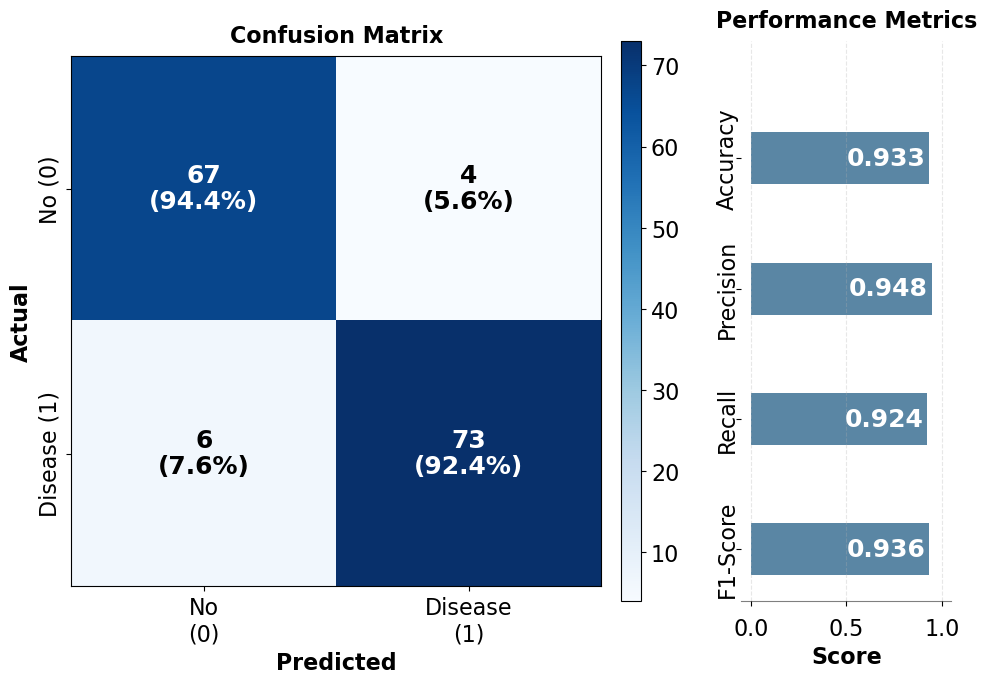

In [ ]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [23]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.86666667 0.87394958 0.87394958 0.81512605 0.87394958]
Mean: 0.8607
Standard Deviation: 0.0230


In [24]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 73.47 seconds
Meta Model Tuning & Training Time: 120.10 seconds
Total SEL-NNML Tuning & Training Time: 193.57 seconds


### **6.2 Multiple Model Evaluation**

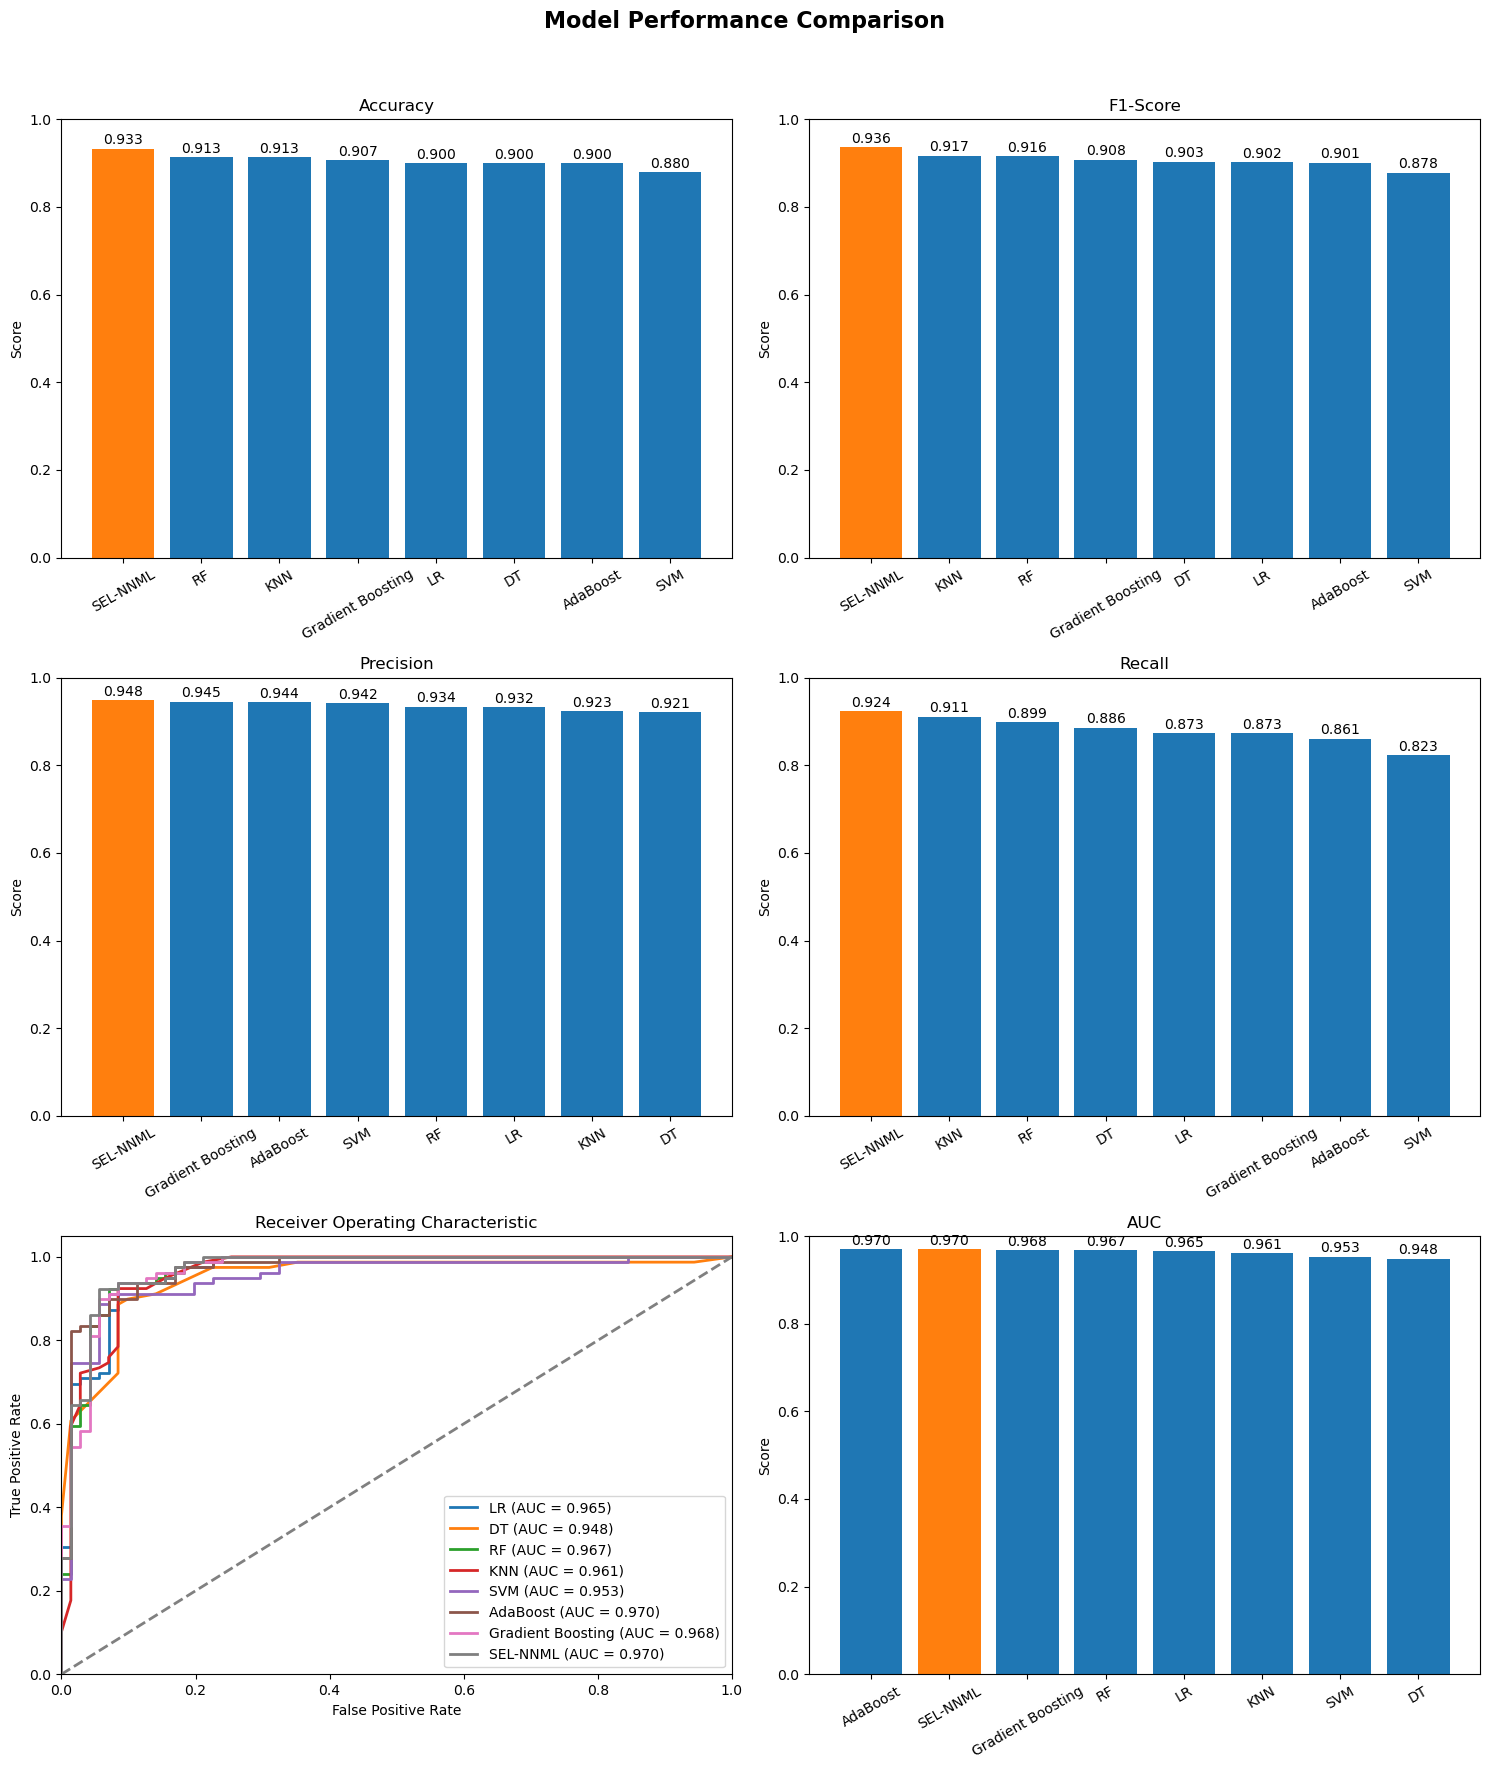

In [25]:
model_comparison_plot(all_models, X_test, y_test)

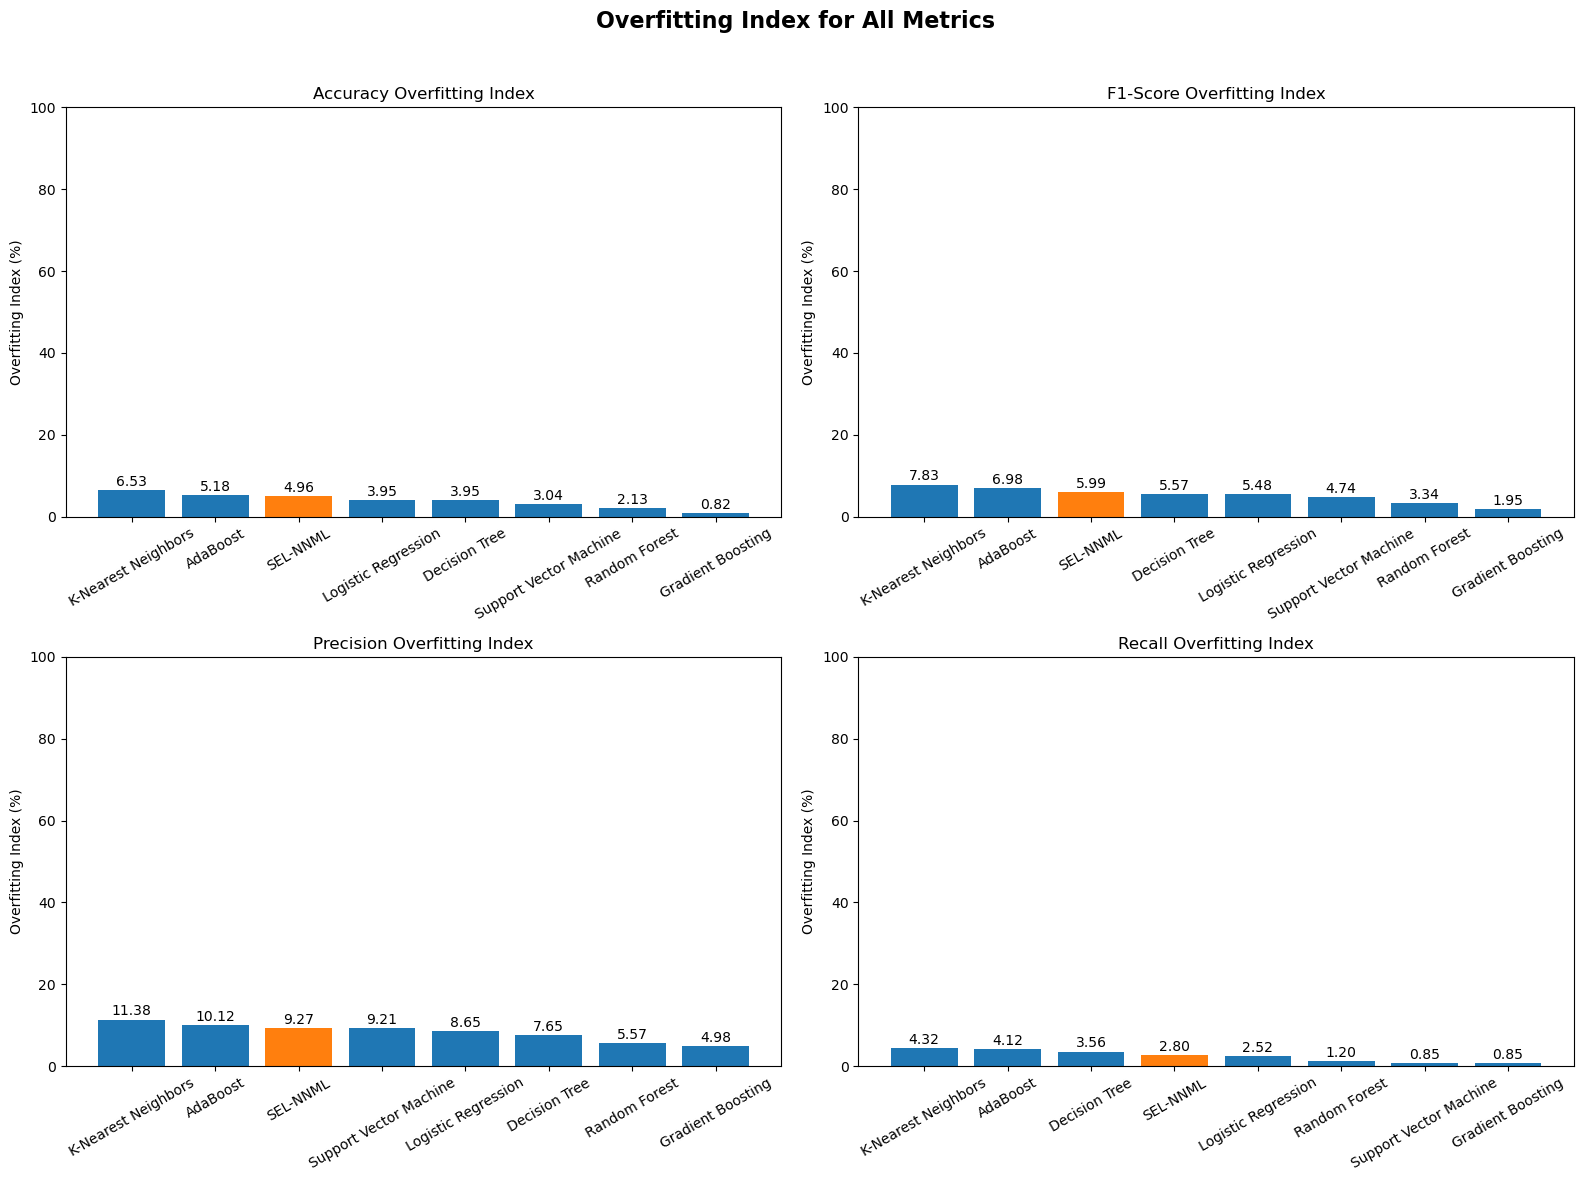

In [26]:
overfitting_index_plot(all_models, X_train, y_train, X_test, y_test)